# Conformal Locally Valid interval-Estimates for Regression

**Clover** is a Python package that introduces a novel class of methods for constructing local prediction intervals around regression point estimates, ensuring local coverage guarantees. Our methodology hinges on the creation of a feature space partition that closely approximates conditional coverage. This is achieved by fitting regression trees and Random Forests on conformity scores.

Our approach finds an optimal balance between theoretical robustness and practical efficiency. We construct prediction intervals that not only offer solid theoretical assurances, including marginal, local, and asymptotic conditional coverage, but also demonstrate superior scalability and performance when compared to conventional baselines. As a result, **clover** provides easily accessible adaptive prediction intervals, offering a more accurate representation of model uncertainty in regression problems.

All methods, experiments and properties are more detailed in the paper:

[Cabezas, L.M.C., Otto M.P., Izbicki R., Stern R.B. (2024). Regression Trees for Fast and Adaptive Prediction Intervals. arXiv preprint arXiv:2402.07357](https://arxiv.org/abs/2402.07357)

## Instalation

Clone the repo and run the following command in the clover directory to install clover

In [ ]:
pip install .

## Tutorial

We propose mainly two new methods to produce prediction intervals in regression problems: **LOCART** and **LOFOREST**.

* **LOCART**: Local Regression Trees (LOCART) is based on creating a partition $\mathcal{A}$ of the feature space, and defining the cutoffs by separately applying conformal prediction to each partition element $A \in \mathcal{A}$. The selection of $\mathcal{A}$ is guided by a data- driven optimization process designed to yield the most accurate estimates of the cutoffs.

* **LOFOREST**: Local Coverage Regression Forests (LOFOREST) builds on Locart by using multiple regression trees on conformity scores to define its prediction interval. That is, LOFOREST is a Random Forest of trees on conformity scores.

We can enhance both methods by strategically incorporating additional features into our feature matrix during the calibration phase. This includes A-LOCART and A-LOFOREST, which can utilize variance (difficulty) estimates, random projections, and other dispersion measures. Importantly, we can circumvent the limitations of dispersion measures by leveraging the feature selection capabilities of both CART and RF algorithms.

In the following tutorial, we show how to properly use our two primary methods, **LOCART** and **LOFOREST**, and, how to use their augmented variants as a bonus.

* **Simulating a heteroscedastic scenario to display the methods usage:**

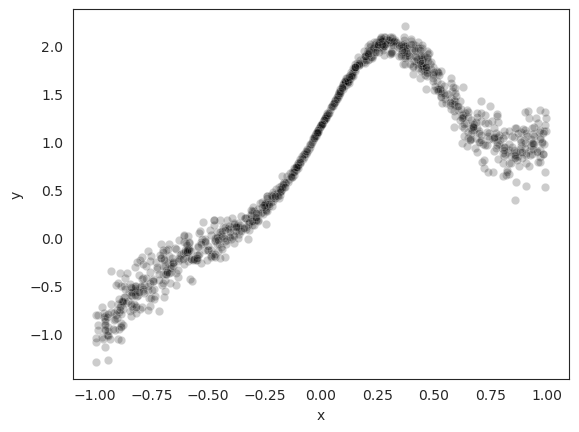

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_variable_data(n, std_dev=1/5):
    x = np.random.uniform(low=-1, high=1, size=n)
    y = (x**3) + 2 * np.exp(-6 * (x - 0.3)**2)
    y = y + np.random.normal(scale=std_dev * np.abs(x), size=n)
    df = pd.DataFrame({'x': x, 'y': y})
    return df

# Set the seaborn style to white
sns.set_style("white")

# Generate the data
df = make_variable_data(1000)

# Create the scatterplot
sns.scatterplot(x='x', y='y', data=df, alpha = 1/5, color = 'black')
plt.show()

* **Let's prepare our training, calibration, and testing datasets. We will be using K-Nearest Neighbors (KNN) as our base model for regression.**

In [2]:
from sklearn.neighbors import KNeighborsRegressor

# Set the random seed
np.random.seed(1500)

# Generate the training, calibration and validation sets
train_df = make_variable_data(1500)
cal_df = make_variable_data(1500)
val_df = make_variable_data(1500) 

# Create the KNN regressor
knn = KNeighborsRegressor(n_neighbors = 50)

# Fit the KNN regressor to the training data
knn.fit(train_df[['x']].values, train_df['y'].values)

KNeighborsRegressor(n_neighbors=50)

* **To compute predictive intervals using LOCART, we first need to define the *LocartSplit* class. This class primarily requires three initial arguments: the chosen conformity score, the base model, and the miscalibration level $\alpha$. The conformity score class can be directly imported from the Clover package, or alternatively, it can be created using the basic *Scores* class in a straightforward manner. In this example, we use the RegressionScore, which represents the mean absolute error. Additionally, we use the optional parameter *is_fitted* to indicate whether the base model has already been fitted. This prevents unnecessary re-training of the model.**

In [3]:
from clover import LocartSplit, RegressionScore
# Set miscalibration level
alpha = 0.1

# Defining the class with conformity score, base model, miscalibration level and is_fitted paramter (optional)
locart = LocartSplit(RegressionScore, knn, alpha = alpha, is_fitted = True)
# fitting the base model to the training set
locart.fit(train_df[['x']].values, train_df['y'].values)

# computing local cutoffs by fitting regression tree to our calibration set
locart.calib(cal_df[['x']].values, cal_df['y'].values)

{1: 0.2754178548446091,
 4: 0.1496540995480944,
 7: 0.06575805778537414,
 8: 0.06196180734978778,
 9: 0.13981516347329614,
 10: 0.26015728856970477}

* **To compute predictive intervals using LOFOREST, we redefine the *LocartSplit* class, this time changing the default value of the *cart_type* parameter to "RF". This parameter determines the method we use in the calibration step (calib), whether it's a single decision tree or a random forest.**

In [4]:
# changing cart_type to "RF" to fit loforest
loforest = LocartSplit(RegressionScore, knn, alpha = alpha, cart_type = "RF", is_fitted = True)

# fitting base model
loforest.fit(train_df[['x']].values, train_df['y'].values)

# computing local cutoffs by fitting random forest to our calibration set
loforest.calib(cal_df[['x']].values, cal_df['y'].values)

[{1: 0.272789376898864,
  4: 0.13357887384392392,
  5: 0.08496169979992507,
  6: 0.24521651783695064},
 {1: 0.2562442629456541,
  4: 0.11421809547184934,
  5: 0.09797065941092525,
  6: 0.24797030851503746},
 {1: 0.272789376898864,
  4: 0.1335832666375209,
  5: 0.0952247826851206,
  6: 0.24797030851503746},
 {2: 0.27528113566405926,
  4: 0.13996859735024125,
  5: 0.0679363429288516,
  6: 0.24403376359903875},
 {2: 0.26326350475116034,
  4: 0.11713609007705242,
  5: 0.11285310026890699,
  6: 0.26045917604835456},
 {1: 0.26327733941280396,
  4: 0.12857057816009132,
  5: 0.08440938639517792,
  6: 0.24521651783695064},
 {1: 0.27909722014059823,
  4: 0.14835222664332703,
  5: 0.08637904329809809,
  6: 0.24797030851503746},
 {1: 0.272789376898864,
  4: 0.13361606616304458,
  5: 0.0891172100356047,
  6: 0.24797030851503746},
 {1: 0.27528113566405926,
  4: 0.14513373847217084,
  5: 0.08637904329809809,
  6: 0.24797030851503746},
 {2: 0.25624732438348524,
  4: 0.12818692334972606,
  5: 0.0999713

* **Next, we will compare our suite of methods with the standard Regression Split. This comparison will help us evaluate the enhancements our methods bring to the table.**


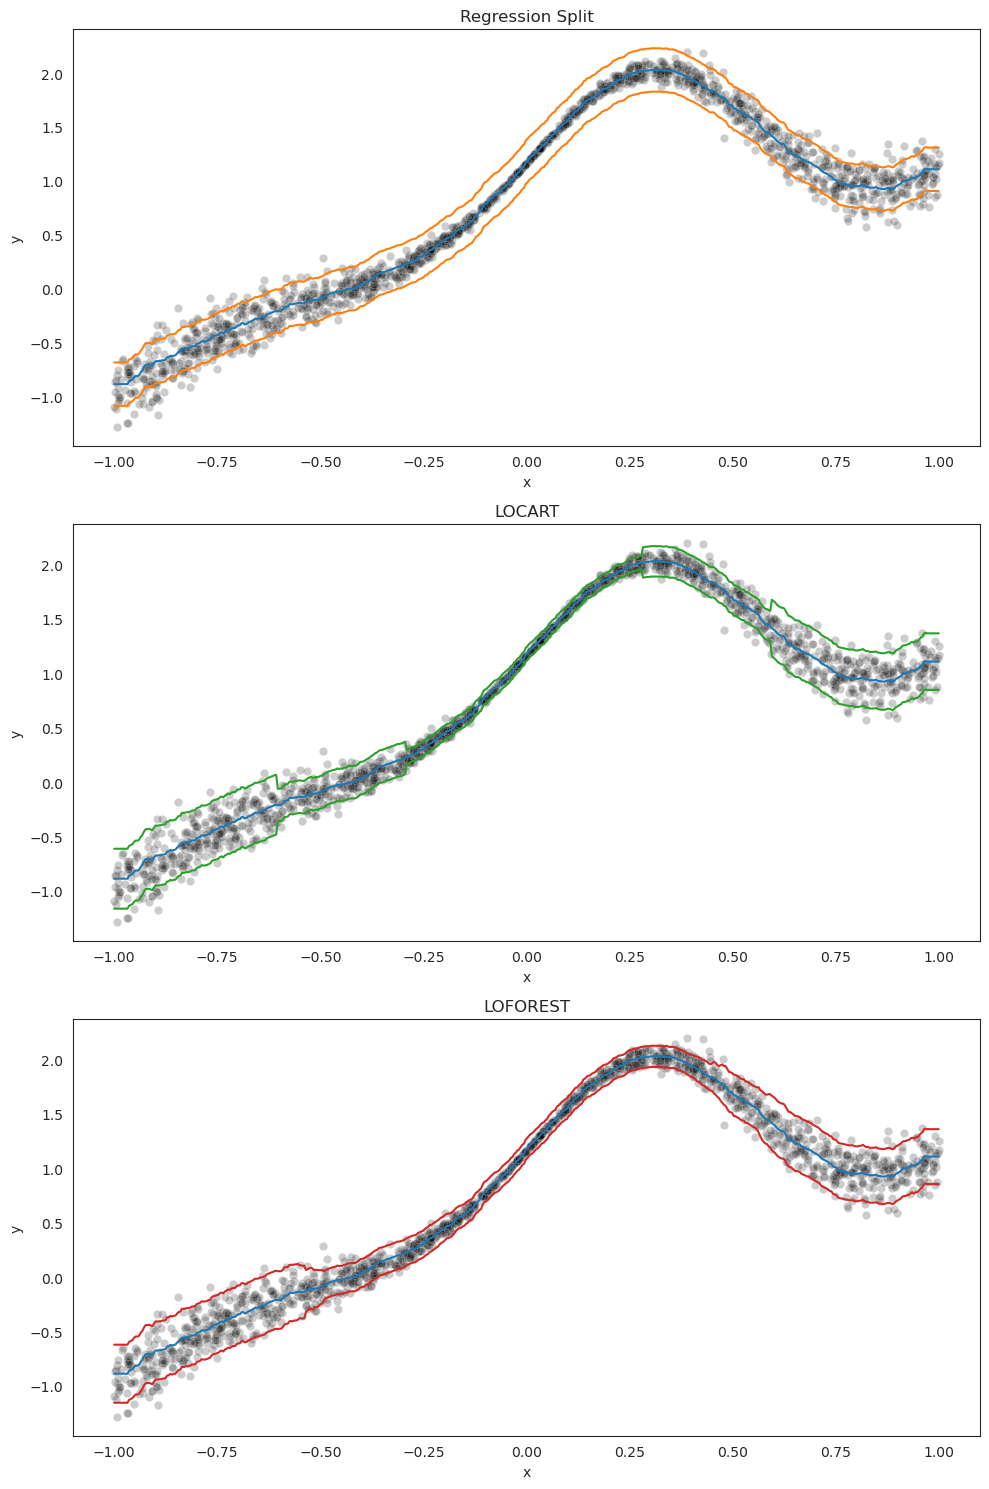

In [5]:
from mapie.regression import MapieRegressor

# fitting mapie
mapie = MapieRegressor(knn, method='base', cv='prefit')
mapie.fit(cal_df[['x']].values, cal_df['y'].values)

# values for prediction intervals
x_values = np.linspace(val_df['x'].min(), val_df['x'].max(), 500).reshape(-1, 1)
y_values = knn.predict(x_values)
y_pred, mapie_values = mapie.predict(x_values, alpha = alpha)
locart_values = locart.predict(x_values)
loforest_values = loforest.predict(x_values)


fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# plot regression split prediction intervals
sns.scatterplot(x='x', y='y', data=val_df, alpha=1/5, color = 'black', ax=axs[0]) 
axs[0].plot(x_values, y_values, color = 'tab:blue')
axs[0].plot(x_values, mapie_values[:,0], color = "tab:orange")
axs[0].plot(x_values, mapie_values[:,1], color = "tab:orange")
# axs[0].legend()  # Commented out to remove legend
axs[0].set_title('Regression Split')

# plot locart prediction intervals
sns.scatterplot(x='x', y='y', data=val_df, alpha=1/5, color = 'black', ax=axs[1]) 
axs[1].plot(x_values, y_values, color = 'tab:blue')
axs[1].plot(x_values, locart_values[:,0], color = "tab:green")
axs[1].plot(x_values, locart_values[:,1], color = "tab:green")
# axs[1].legend()  # Commented out to remove legend
axs[1].set_title('LOCART')

# plot locart prediction intervals
sns.scatterplot(x='x', y='y', data=val_df, alpha=1/5, color = 'black', ax=axs[2]) 
axs[2].plot(x_values, y_values, color = 'tab:blue')
axs[2].plot(x_values, loforest_values[:,0], color = "tab:red")
axs[2].plot(x_values, loforest_values[:,1], color = "tab:red")
# axs[2].legend()  # Commented out to remove legend
axs[2].set_title('LOFOREST')

plt.tight_layout()
plt.show()

* **We can also apply A-LOCART to the same problem simply by changing the *weighting* parameter from False to True.**

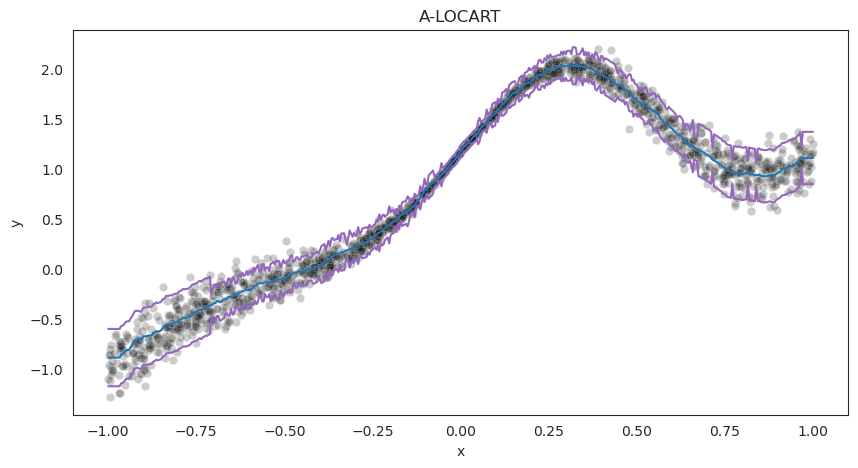

In [14]:
# Changing the weighting parameter from False to True
a_locart = LocartSplit(RegressionScore, knn, alpha = alpha, is_fitted = True, weighting = True)

# fitting the base model to the training set
a_locart.fit(train_df[['x']].values, train_df['y'].values)

# computing local cutoffs by fitting regression tree to our calibration set
a_locart.calib(cal_df[['x']].values, cal_df['y'].values)

a_locart_values = a_locart.predict(x_values)

plt.figure(figsize = (10, 5))
sns.scatterplot(x='x', y='y', data=val_df, alpha=1/5, color = 'black') 
plt.plot(x_values, y_values, color = 'tab:blue')
plt.plot(x_values, a_locart_values[:,0], color = "tab:purple")
plt.plot(x_values, a_locart_values[:,1], color = "tab:purple")
plt.title('A-LOCART')
plt.show()

## Remark

While our framework is primarily designed to generate prediction intervals for regression problems, it's versatile enough to handle quantile regression and even conditional distributions. This is achieved by supplying the appropriate conformity score class and base model for quantile regression or conditional distribution. However, the application of **LOCART** and **LOFOREST** in these contexts is still under investigation by the authors.